In [2]:
#SOURCES

#http://cshprotocols.cshlp.org/content/2015/4/pdb.top086124.long
#https://scipy-cookbook.readthedocs.io/items/FittingData.html

In [3]:
#IMPORTING DEPENDENCIES

import cv2
from skimage.transform import rescale, resize, downscale_local_mean

import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D

from astropy.modeling import models, fitting
import warnings

import matplotlib.cm as cm
import sklearn.preprocessing

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage as ndimage

from skimage.draw import line
from skimage.draw import line_aa

In [4]:
#FUNCTIONS

def crop_center(img,cropx,cropy):
    """Crop a centered rectangle or square"""
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

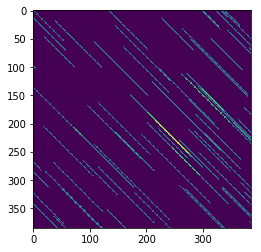

In [89]:
npixels=384
simfibimg=np.ones((npixels+1,npixels+1))

#M = cv2.getRotationMatrix2D((cols/2,rows/2),rotangle,1)

xaxis=np.linspace(0,npixels,npixels+1)
yaxis=np.linspace(0,npixels,npixels+1)

xaxis,yaxis=np.meshgrid(xaxis,yaxis)

numfibers=200
minthickness=1
maxthickness=5

for i in range(1,numfibers):
    
    simfibimgearly=np.zeros((npixels+1,npixels+1))
    x_start=np.random.randint(-npixels,npixels)
    y_start=np.random.randint(-npixels,npixels)
    #x_start=0
    #y_start=npixels/2
    #rotangle=np.random.randint(15,45)
    rotangle=45
    rotanglerad=rotangle*np.pi/180
    #rotangle=45
    #length=npixels
    length=np.random.randint(npixels/5,npixels/2)
    #period=npixels/5
    #thickness=np.random.randint(minthickness,maxthickness)
    thickness=1
    x_end=length*np.cos(rotanglerad)+x_start
    y_end=length*np.sin(rotanglerad)+y_start
    
    x_end=np.round(x_end).astype(int)
    y_end=np.round(y_end).astype(int)
    
    
    rr,cc,val=line_aa(x_start,y_start,x_end,y_end)
    
    for j in range(1,thickness):
        rr=np.append(rr,rr)
        cc=np.append(cc,cc+j)
    
    goodpositions=np.where(np.logical_and(np.logical_and(rr<=npixels,cc<=npixels),np.logical_and(rr>=0,cc>=0)))[0]

    fiber_x=rr[goodpositions]
    fiber_y=cc[goodpositions]
    


    fiber_x=np.round(fiber_x).astype(int)
    fiber_y=np.round(fiber_y).astype(int)
    
    for x,y in zip(fiber_x,fiber_y):
        simfibimgearly[y,x]=1000

    simfibimg=simfibimg+simfibimgearly
    
plt.imshow(simfibimg)
plt.show()

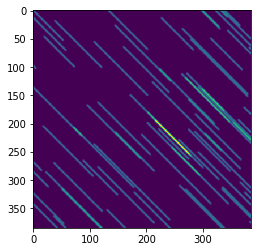

In [90]:
gausskern=cv2.GaussianBlur(simfibimg,(5,5),0)
plt.imshow(gausskern)
plt.show()

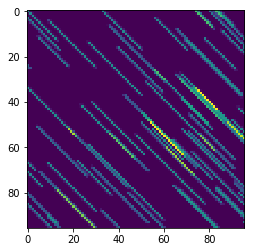

97.05327048511417

In [109]:
image=gausskern
image_rescaled = rescale(image, 1.0 / 4.0,mode='constant')
plt.imshow(image_rescaled)
plt.show()
#image=gausskern
#image_rescaled = rescale(image, 1.0 / 4.0,mode='constant')
#plt.imshow(image_rescaled)
plt.show()
np.average(image_rescaled)


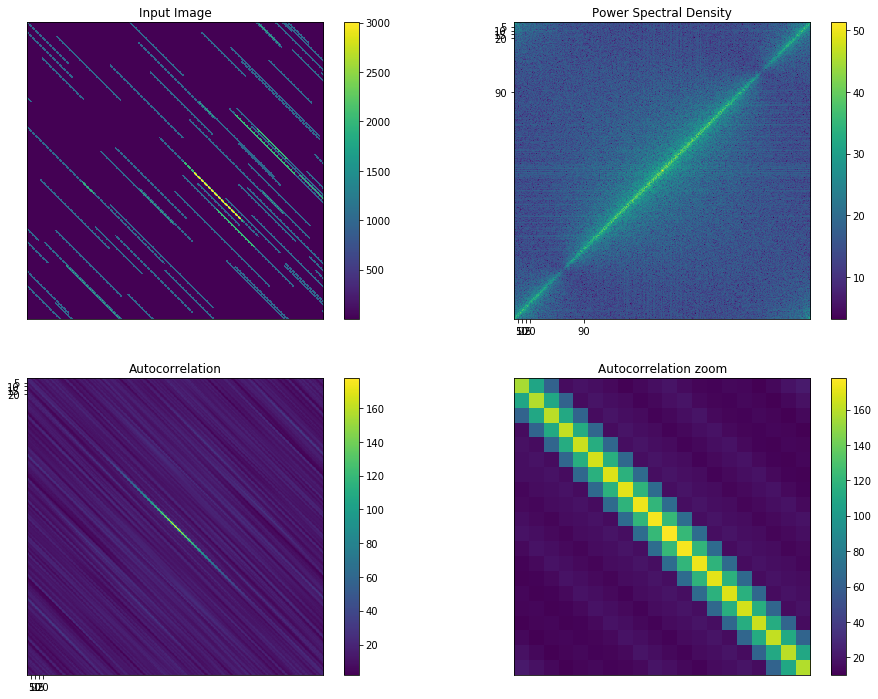

In [112]:
#AUTOCORRELATION

#imgforft=gausskern*1
imgforft=simfibimg*1
#imgforft=image_rescaled*1
#plotcorr=np.real(np.fft.fft2(imgforft))

dft = cv2.dft(np.float32(imgforft),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

myPSD=(np.log10(abs(np.fft.fftshift(np.fft.fft2(imgforft)))))**2
    
plotcorr=(np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(imgforft)*np.conjugate(np.fft.fft2(imgforft)))))/((np.mean(imgforft)*np.mean(imgforft)*100*100 )))-1

plotcorrzoom=crop_center(plotcorr,20,20)

magnitude_spectrum = np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
#powerspectraldensity = magnitude_spectrum**2
plt.figure(figsize=(16,12))
plt.subplot(221),plt.imshow(imgforft)
plt.colorbar()
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(myPSD)
plt.colorbar()
plt.title('Power Spectral Density'), plt.xticks([5,10,15,20,90]), plt.yticks([5,10,15,20,90])
plt.subplot(223),plt.imshow(plotcorr)
plt.colorbar()
plt.title('Autocorrelation'), plt.xticks([5,10,15,20]), plt.yticks([5,10,15,20])
plt.subplot(224),plt.imshow(plotcorrzoom)
plt.colorbar()
plt.title('Autocorrelation zoom'), plt.xticks([]), plt.yticks([])
plt.show()


In [93]:
density=1/(plotcorr[50,50])
#(density,plotcorr[12,12])
density

0.054642360738857365

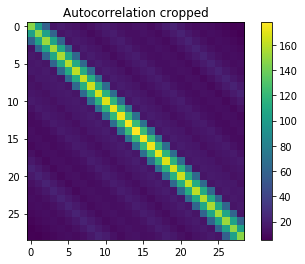

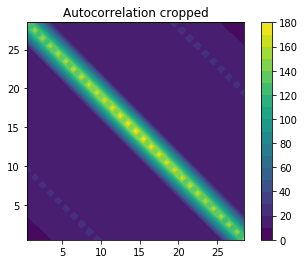

In [94]:
#newimg=crop_center(plotcorr,100,200)*1
newimg=crop_center(plotcorr,29,29)
plt.imshow(newimg)
plt.colorbar()
plt.title('Autocorrelation cropped')
plt.show()
plt.contourf(newimg,20,origin='upper')
plt.colorbar()
plt.title('Autocorrelation cropped')
plt.gca().axes.set_aspect('equal')
plt.show()


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage as ndimage
 
mat=newimg*1
rows, cols = mat.shape
xv, yv = np.meshgrid(range(cols), range(rows)[::-1])
 


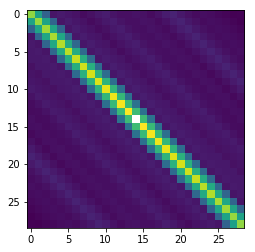

In [95]:
#ignore max point when f
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(newimg)
newimgmask=newimg*1
newimgmask[max_loc]=np.nan

#newimgmask[max_loc]=0
plt.imshow(newimgmask)
plt.show()

In [96]:
mat=newimgmask*1
newimg2=newimgmask*1

rows, cols = mat.shape
xv, yv = np.meshgrid(range(cols), range(rows)[::-1])


mask1=np.ma.masked_invalid(newimg2)

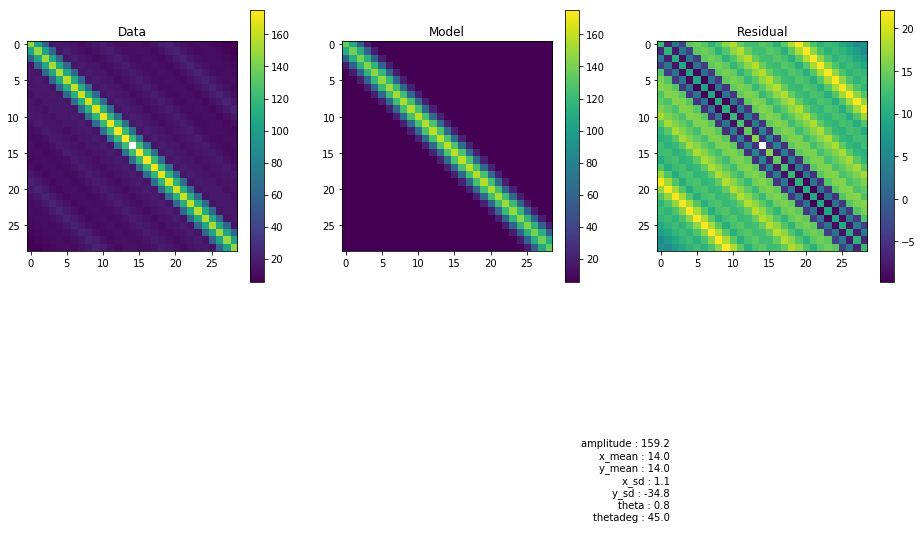

In [97]:
import scipy.optimize

def scipyFunc(parameters, xv,yv, image):
    amplitude,x_mean,y_mean,x_stddev,y_stddev,theta=parameters
    p = models.Gaussian2D(amplitude=amplitude,x_mean=x_mean,y_mean=y_mean,x_stddev=x_stddev,y_stddev=y_stddev,theta=theta)
    return np.nanmean((image-p(xv,yv))**2)


cols,rows=newimgmask.shape

fitted=scipy.optimize.minimize(scipyFunc,(4,cols/2,rows/2,1,1,0),(xv,yv,mask1)).x

amplitude,x_mean,y_mean,x_stddev,y_stddev,theta=fitted
p = models.Gaussian2D(amplitude=amplitude,x_mean=x_mean,y_mean=y_mean,x_stddev=x_stddev,y_stddev=y_stddev,theta=theta)


# Plot the data with the best-fit model
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.imshow(mask1, interpolation='nearest',vmax=np.nanmax(mask1),vmin=np.nanmin(mask1))
plt.title("Data")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(p(xv, yv), interpolation='nearest',vmax=np.nanmax(mask1),vmin=np.nanmin(mask1))
plt.title("Model")
ax = plt.gca()
thetadeg=p.theta.value*180/np.pi
plt.text(1.56, -1.4, """
amplitude : %.1f
x_mean : %.1f
y_mean : %.1f
x_sd : %.1f
y_sd : %.1f
theta : %.1f
thetadeg : %.1f

""" %(amplitude,x_mean,y_mean,x_stddev,y_stddev,theta,thetadeg),
        fontsize=10, horizontalalignment='right',
        verticalalignment='bottom', transform=ax.transAxes)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(newimg2 - p(xv, yv), interpolation='nearest')
plt.title("Residual")
plt.colorbar()
plt.show()


In [98]:
scipyFunc(fitted,xv,yv, mask1)

172.9172605898895

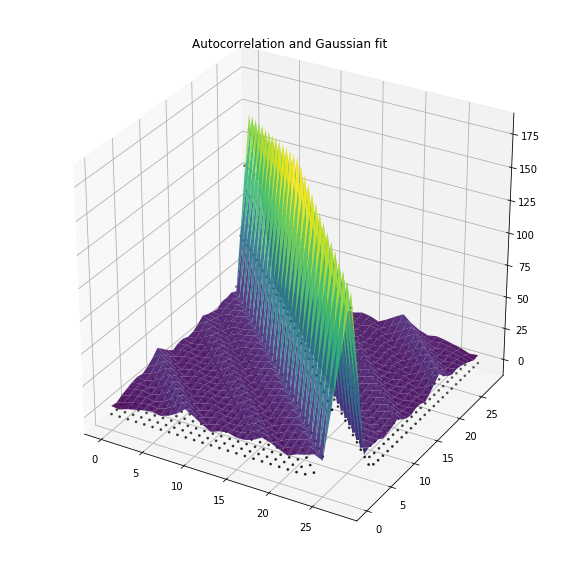

In [99]:

fig=plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(xv, yv, p(xv,yv), c='black', s=3)
ax.plot_surface(xv, yv, newimg, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none',alpha=0.9)

ax.set_title('Autocorrelation and Gaussian fit');
plt.show()

In [100]:
mat2=myPSD*1

rows, cols = mat2.shape
xvb, yvb = np.meshgrid(range(cols), range(rows)[::-1])



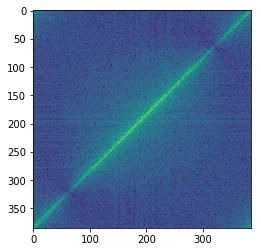

In [101]:
plt.imshow(mat2)
plt.show()

In [102]:
xvbc=xvb-cols/2
yvbc=yvb-rows/2

zipme=zip(xvbc,yvbc)

r=xvbc*1
theta=xvbc*1


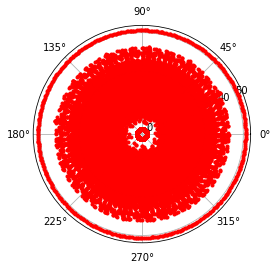

In [103]:
source = mat2*1

#--- ensure image is of the type float ---
img = source.astype(np.float32)

#--- the following holds the square root of the sum of squares of the image dimensions ---
#--- this is done so that the entire width/height of the original image is used to express the complete circular range of the resulting polar image ---
value = np.sqrt(((img.shape[0]/2.0)**2.0)+((img.shape[1]/2.0)**2.0))

polar_image = cv2.linearPolar(img,(img.shape[0]/2, img.shape[1]/2), value, cv2.WARP_FILL_OUTLIERS)

#polar_image = polar_image.astype(np.uint8)
#cv2.imshow("Polar Image", polar_image)
#cv2.waitKey(0)
ax = plt.subplot(111, polar=True)
ax.plot(polar_image, color='r', ls='none', marker='.')
#ax.scatter(polar_image, cmap='hsv', alpha=0.75)

#ax.plot(polar_image, color='r', linewidth=3)
#data_theta_rad, data_r, color='r', linewidth=3
plt.show()

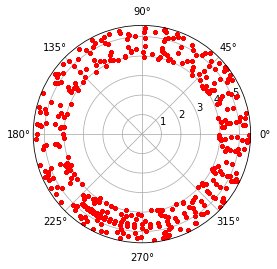

In [88]:
import PIL

mat3=myPSD*1

rows, cols = mat3.shape
xvb, yvb = np.meshgrid(range(cols), range(rows)[::-1])

width=cols
height=rows

maxradius = np.sqrt(width**2 + height**2)/2
rscale = width / maxradius
tscale = height / (2*np.pi)

rmap=[]
tmap=[]

#tmap=
i=0
for y in range(0, height):
    dyx = y - height/2
    for x in range(0, width):
        dx = x - width/2
        t =  np.arctan2(dy,dx)%(2*np.pi)
        r = np.sqrt(dx**2+dy**2)
        rmap.append(r)
        tmap.append(t)
        
        
        
        
ax = plt.subplot(111, polar=True)
ax.plot(rmap,tmap, color='r', ls='none', marker='.')
#ax.scatter(polar_image, cmap='hsv', alpha=0.75)

#ax.plot(polar_image, color='r', linewidth=3)
#data_theta_rad, data_r, color='r', linewidth=3
plt.show()
     #color = getColor(getPixel(pic, x, y))
     #setColor( getPixel(radial,int(r*rscale),int(t*tscale)), color)

In [85]:
t

5.4951829830023255

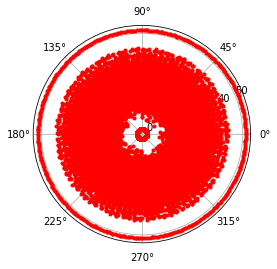

In [21]:
ax = plt.subplot(111, polar=True)
ax.plot(polar_image, color='r', ls='none', marker='.')
plt.show()